# Analysing and Predicting Churn rate of users of 'Audiobook' app

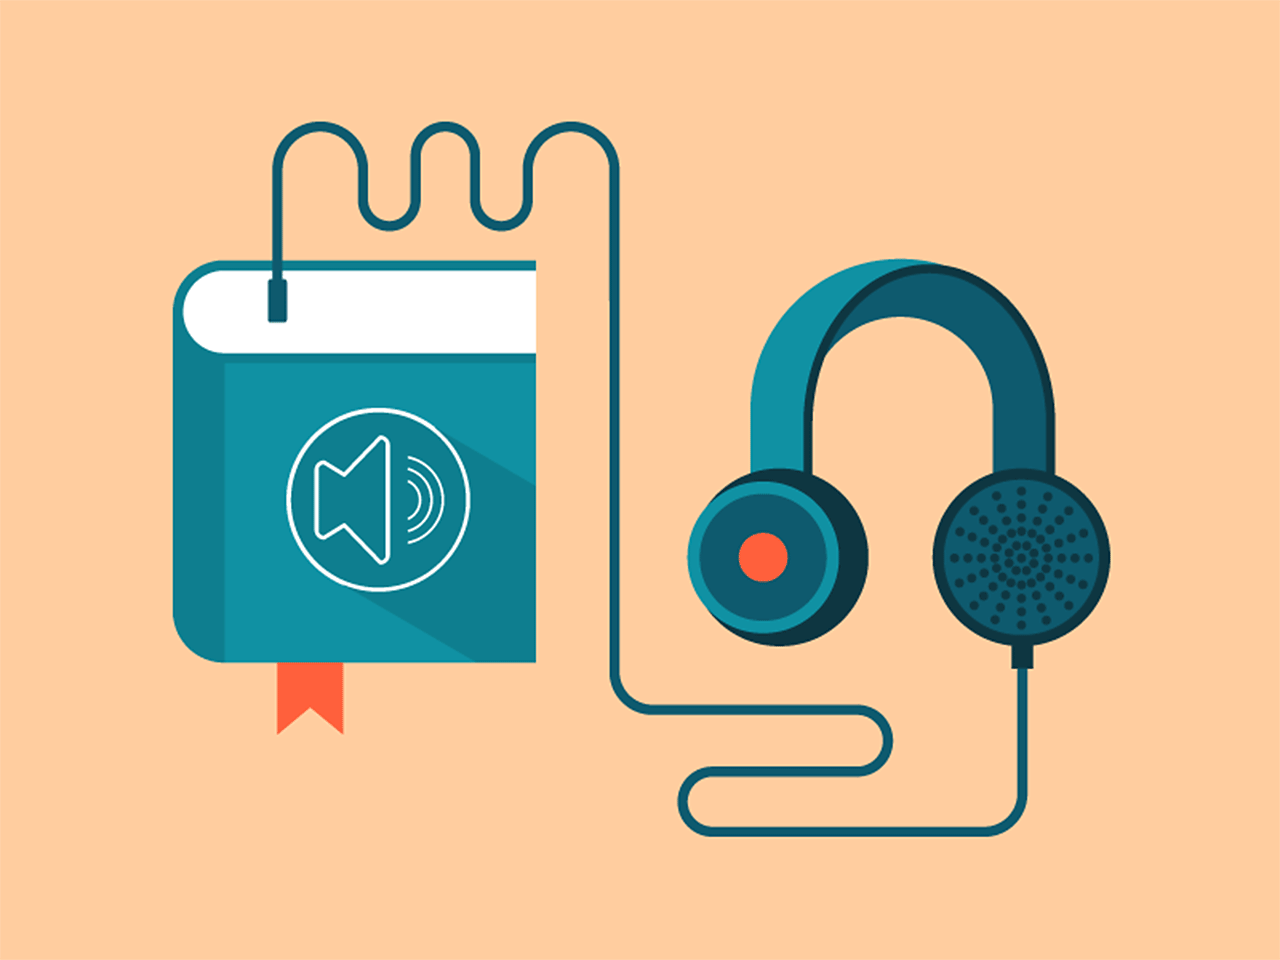

You are given data from an Audiobook app. Logically, it relates only to the audio versions of books.  We want to create a machine learning model based on our available data that can predict if a customer will buy again from the Audiobook company.

- The data is from an audiobook app, each customer in the database has make a purchase at least once.
- The main idea is that the company shouldn't spend there money targeting individuals who are unlikely to come back.
- If we focus on client who are more likely to convert again we'll get increase the sales and profitability figures.

The model must show us which are the most important metrics for a client to come back.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

plt.style.use('seaborn')

%matplotlib inline
sns.set_style("whitegrid")

pd.set_option("display.max_columns", 80)
pd.set_option("display.max_rows", 80)
pd.set_option("display.float_format", "{:.2f}".format)

In [2]:
data = pd.read_csv("audiobook_data_2.csv", index_col=0)
data.head()

,Book_length(mins)_overall,Book_length(mins)_avg,Price_overall,Price_avg,Review,Review10/10,Completion,Minutes_listened,Support_Request,Last_Visited_mins_Purchase_date,Target
994,1620.00,1620,19.73,19.73,1,10.00,0.99,1603.80,5,92,0
1143,2160.00,2160,5.33,5.33,0,8.91,0.00,0.00,0,0,0
2059,2160.00,2160,5.33,5.33,0,8.91,0.00,0.00,0,388,0
2882,1620.00,1620,5.96,5.96,0,8.91,0.42,680.40,1,129,0
3342,2160.00,2160,5.33,5.33,0,8.91,0.22,475.20,0,361,0


In [3]:
count = (data['Review']).value_counts()[0]
print("Number of users who didnt give reviews are : ", count, " out of 14084")

Number of users who didnt give reviews are :  11820  out of 14084


# 1. Getting aquainted with the dataset

- `ÌD`: is like a name.

- `Book_length(mins)_overall`: is the sum of the lengths of purchases.

- `Book_length(mins)_avg`: is the sum of the lengths of purchases divided by the number of purchases. Notice we don't need the number of purchases column because we ca get it from `Book_length(mins)_overall` / `Book_length(mins)_avg`.

- `Price_overall` & `Price_avg`: Same as Book length, the price variable is almost always a good predictor.

- `Review`: is boolean. It shows if the customer left a review. If so, `Review10/10` saves the review left by the user. While most users don't left a review we fill the missing reviews by avrage review column.

- `Minutes_listened`: is a measure of engagement, the total of minutes the user listen to audiobooks.

- `Completion`: is the `Minutes_listened` / `Book_length(mins)_overall`.

- `Support_Request`: Shows the total number of support request (forgotten password to assistance).

- `Last_Visited_mins_Purchase_date`: the bigger the difference, the bigger sooner the engagement. If the value is 0, we are sure the customer has never accessed what he/she has bought.

The data was gathered from the audiobook app, the input data represents `2 years` worth of engagement. We are doing supervised learning so we need `target`. We took extra `6 month` to check if the user converted or not. 1 if the customer buys in the next 6 months, 0 if the customer didn't.

- `target`: 1 if the customer bought again in the last 6 months of data. 0 if the customer did not buy again.

# 2. Exploratory Data Analysis

In [4]:
data.describe()

,Book_length(mins)_overall,Book_length(mins)_avg,Price_overall,Price_avg,Review,Review10/10,Completion,Minutes_listened,Support_Request,Last_Visited_mins_Purchase_date,Target
count,14084.00,14084.00,14084.00,14084.00,14084.00,14084.00,14084.00,14084.00,14084.00,14084.00,14084.00
mean,1591.28,1678.61,7.10,7.54,0.16,8.91,0.13,189.89,0.07,61.94,0.16
std,504.34,654.84,4.93,5.56,0.37,0.64,0.24,371.08,0.47,88.21,0.37
min,216.00,216.00,3.86,3.86,0.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,1188.00,1188.00,5.33,5.33,0.00,8.91,0.00,0.00,0.00,0.00,0.00
50%,1620.00,1620.00,5.95,6.07,0.00,8.91,0.00,0.00,0.00,11.00,0.00
75%,2160.00,2160.00,8.00,8.00,0.00,8.91,0.13,194.40,0.00,105.00,0.00
max,2160.00,7020.00,130.94,130.94,1.00,10.00,1.00,2160.00,30.00,464.00,1.00


In [5]:
data.isnull().sum()

Book_length(mins)_overall          0
Book_length(mins)_avg              0
Price_overall                      0
Price_avg                          0
Review                             0
Review10/10                        0
Completion                         0
Minutes_listened                   0
Support_Request                    0
Last_Visited_mins_Purchase_date    0
Target                             0
dtype: int64

### data.info()

## `Book_length(mins)_overall` & `Book_length(mins)_avg`

- `Book_length(mins)_overall`: is the sum of the lengths of purchases.

- `Book_length(mins)_avg`: is the sum of the lengths of purchases divided by the number of purchases. Notice we don't need the number of purchases column because we ca get it from `Book_length(mins)_overall` / `Book_length(mins)_avg`.

In [6]:
data['Book_length(mins)_overall'].value_counts()

2160.00    4712
1620.00    4149
1188.00    2851
648.00      712
1080.00     567
324.00      300
540.00      115
1404.00     112
1890.00     110
1674.00      98
1134.00      52
216.00       51
1656.00      27
1476.00      23
1350.00      21
756.00       21
918.00       15
1332.00      14
864.00       13
1242.00      13
1296.00      10
1152.00       8
972.00        7
1116.00       7
486.00        6
1377.00       5
1224.00       5
1512.00       5
1368.00       5
594.00        4
432.00        4
1044.00       4
702.00        3
1008.00       3
684.00        3
1161.00       2
1269.00       2
504.00        2
576.00        2
945.00        1
720.00        1
1231.20       1
990.00        1
378.00        1
1170.00       1
1098.00       1
1252.80       1
828.00        1
1058.40       1
928.80        1
999.00        1
810.00        1
1431.00       1
1440.00       1
1002.86       1
1062.00       1
1339.20       1
270.00        1
612.00        1
1260.00       1
Name: Book_length(mins)_overall, dtype: 

In [7]:
def book_length(length):
    if length > 1200:
        return 1
    else:
        return 0
    
data['purchases_hour_>3h'] = data['Book_length(mins)_overall'].apply(book_length)

In [8]:
data['Book_length(mins)_avg'].apply(book_length).value_counts()

1    9480
0    4604
Name: Book_length(mins)_avg, dtype: int64

In [9]:
data['purchases_hour_>3h'].value_counts()

1    9317
0    4767
Name: purchases_hour_>3h, dtype: int64

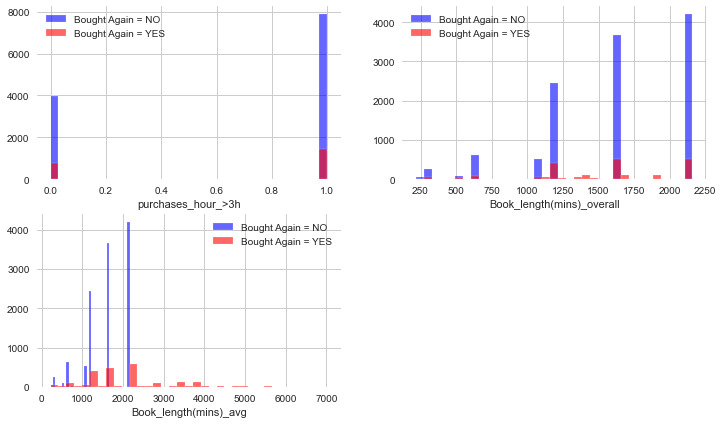

In [10]:
columns = ['purchases_hour_>3h', 'Book_length(mins)_overall', 'Book_length(mins)_avg']
plt.figure(figsize=(12, 7))

for i, column in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    data[data["Target"] == 0][column].hist(bins=35, color='blue', label='Bought Again = NO', alpha=0.6)
    data[data["Target"] == 1][column].hist(bins=35, color='red', label='Bought Again = YES', alpha=0.6)
    plt.legend()
    plt.xlabel(column)

## `Price_overall` & `Price_avg`

- `Price_overall` & `Price_avg`: Same as Book length, the price variable is almost always a good predictor.

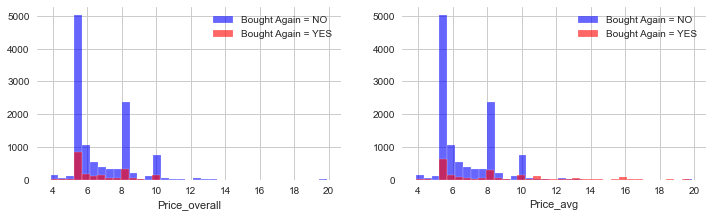

In [11]:
columns = ["Price_overall", "Price_avg"]
plt.figure(figsize=(12, 7))
df = data[(data.Price_overall < 20) & (data.Price_avg < 20)]

for i, column in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    df[df["Target"] == 0][column].hist(bins=35, color='blue', label='Bought Again = NO', alpha=0.6)
    df[df["Target"] == 1][column].hist(bins=35, color='red', label='Bought Again = YES', alpha=0.6)
    plt.legend()
    plt.xlabel(column)

## `Review` & `Review10/10`
- `Review`: is boolean. It shows if the customer left a review. If so, `Review10/10` saves the review left by the user. While most users don't left a review we fill the missing reviews by avrage review column.

In [12]:
print(data[data['Review'] == 0].Target.value_counts(normalize=True))
print(data[data['Review'] == 1].Target.value_counts(normalize=True))

0   0.84
1   0.16
Name: Target, dtype: float64
0   0.83
1   0.17
Name: Target, dtype: float64


In [13]:
data['Review10/10'].value_counts()

8.91     11616
10.00     1284
8.00       404
9.00       381
7.00       157
6.00       104
5.00        43
9.50        21
4.00        18
8.50        11
1.00        10
3.00         9
2.00         7
6.50         5
8.33         2
5.50         2
8.67         2
7.50         2
6.67         1
1.50         1
9.40         1
7.75         1
4.50         1
9.67         1
Name: Review10/10, dtype: int64

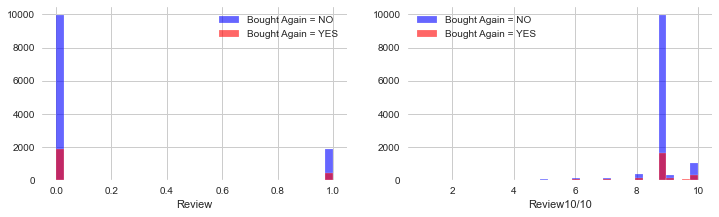

In [14]:
columns = ["Review", "Review10/10"]
plt.figure(figsize=(12, 7))

for i, column in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    data[data["Target"] == 0][column].hist(bins=35, color='blue', label='Bought Again = NO', alpha=0.6)
    data[data["Target"] == 1][column].hist(bins=35, color='red', label='Bought Again = YES', alpha=0.6)
    plt.legend()
    plt.xlabel(column)

## `Minutes_listened` & `Completion`
- `Minutes_listened`: is a measure of engagement, the total of minutes the user listen to audiobooks.
- `Completion`: is the `Minutes_listened` / `Book_length(mins)_overall`.

In [15]:
def listened_to_books(minutes):
    if minutes > 0.0:
        return 0
    else:
        return 1
data['listened_to_books'] = data.Minutes_listened.apply(listened_to_books)

In [16]:
def completion_state(minutes):
    if minutes > 0.5:
        return 1
    else:
        return 0
data['completion_state'] = data.Completion.apply(completion_state)

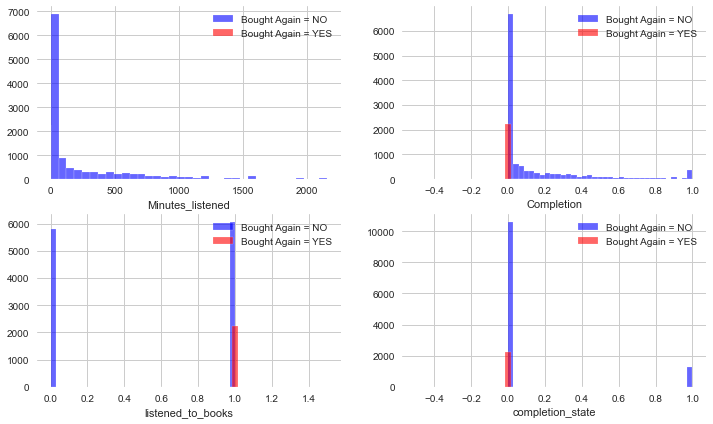

In [17]:
columns = ["Minutes_listened", "Completion", "listened_to_books", "completion_state"]
plt.figure(figsize=(12, 7))

for i, column in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    data[data["Target"] == 0][column].hist(bins=35, color='blue', label='Bought Again = NO', alpha=0.6)
    data[data["Target"] == 1][column].hist(bins=35, color='red', label='Bought Again = YES', alpha=0.6)
    plt.legend()
    plt.xlabel(column)

In [18]:
data.drop('Minutes_listened', axis=1, inplace=True)

## `Support_Request` & `Last_Visited_mins_Purchase_date`

- `Support_Request`: Shows the total number of support request (forgotten password to assistance).
- `Last_Visited_mins_Purchase_date`: the bigger the difference, the bigger sooner the engagement. If the value is 0, we are sure the customer has never accessed what he/she has bought.

In [19]:
def asked_for_request(request):
    if request == 0:
        return 0
    else:
        return 1
    
data["asked_for_request"] = data.Support_Request.apply(asked_for_request)

In [20]:
def acc_purchases(purchase):
    if purchase == 0:
        return 0
    else:
        return 1
data['acc_purchases'] = data.Last_Visited_mins_Purchase_date.apply(acc_purchases)

In [21]:
data.Last_Visited_mins_Purchase_date.value_counts()

0      5493
1       357
2       198
3       165
5       140
       ... 
354       1
338       1
369       1
464       1
379       1
Name: Last_Visited_mins_Purchase_date, Length: 371, dtype: int64

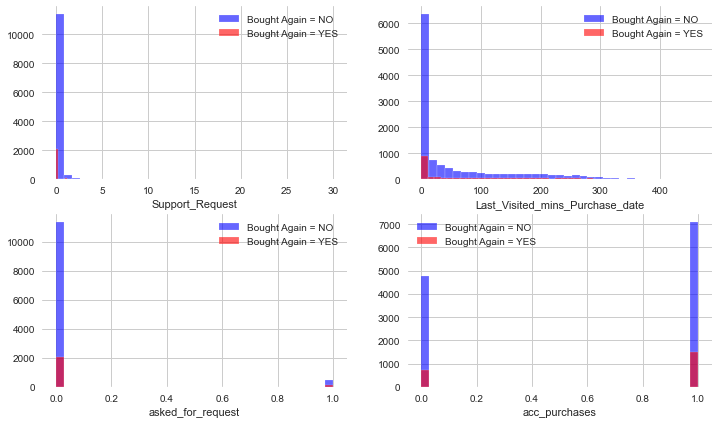

In [22]:
columns = ["Support_Request", "Last_Visited_mins_Purchase_date", "asked_for_request", "acc_purchases"]
plt.figure(figsize=(12, 7))

for i, column in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    data[data["Target"] == 0][column].hist(bins=35, color='blue', label='Bought Again = NO', alpha=0.6)
    data[data["Target"] == 1][column].hist(bins=35, color='red', label='Bought Again = YES', alpha=0.6)
    plt.legend()
    plt.xlabel(column)

In [23]:
data.drop('Support_Request', axis=1, inplace=True)

In [24]:
print(f"{data.Target.value_counts()}")
print(f"{data.Target.value_counts()[0] / data.Target.value_counts()[1]}")

0    11847
1     2237
Name: Target, dtype: int64
5.295932051855163


It is important to notice that our `target` variable is inbabalanced. We have only `2237` user who convert again in the `6 month` period. The data need to be balanced.

<AxesSubplot:>

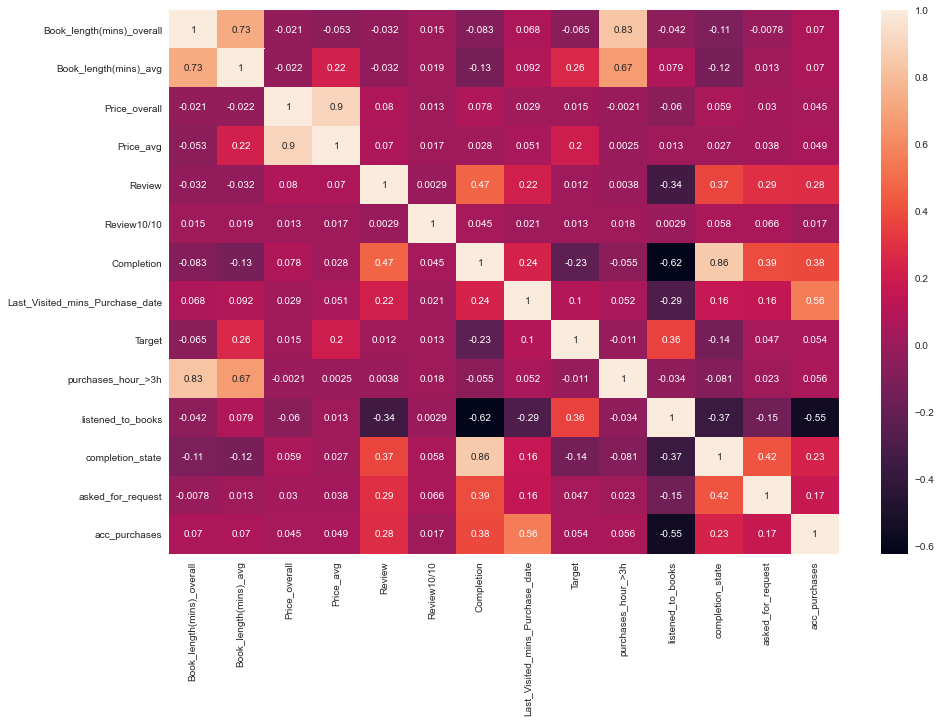

In [25]:
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), annot=True)

# 3. Data Pre-processing

Since we are dealing with real life data, we will need to preprocess it a bit. This is the relevant code which is not that hard but refers to data engineering more than machine learning.

- Removing Duplicates
- Standardising 
- Shuffling 
- Splitting 

### Loading data

In [26]:
r_data = pd.read_csv("audiobook_data_2.csv", index_col=0)


### Removing duplicates

In [27]:
print(f"Data shape before removing duplicates: {r_data.shape}")

# Remove duplicate Features
r_data = r_data.T.drop_duplicates()
r_data = r_data.T

# Remove Duplicate Rows
r_data.drop_duplicates(inplace=True)

print(f"Data shape after removing duplicates: {r_data.shape}")

Data shape before removing duplicates: (14084, 11)
Data shape after removing duplicates: (9350, 11)


In [28]:
X = r_data.loc[:, r_data.columns != 'Target']
y = r_data.loc[:, r_data.columns == 'Target']

raw_csv_data = np.loadtxt('audiobook_data_2.csv', delimiter = ',', skiprows=1)

unscaled_inputs_all = raw_csv_data[:,1:-1]

targets_all = raw_csv_data[:,-1]
raw_csv_data

array([[9.9400e+02, 1.6200e+03, 1.6200e+03, ..., 5.0000e+00, 9.2000e+01,
        0.0000e+00],
       [1.1430e+03, 2.1600e+03, 2.1600e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0590e+03, 2.1600e+03, 2.1600e+03, ..., 0.0000e+00, 3.8800e+02,
        0.0000e+00],
       ...,
       [3.1134e+04, 2.1600e+03, 2.1600e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.2832e+04, 1.6200e+03, 1.6200e+03, ..., 0.0000e+00, 9.0000e+01,
        0.0000e+00],
       [2.5100e+02, 1.6740e+03, 3.3480e+03, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00]])

In [29]:
X.shape

(9350, 10)

In [30]:
y.shape

(9350, 1)

### Standardization

In [31]:
X.head()

,Book_length(mins)_overall,Book_length(mins)_avg,Price_overall,Price_avg,Review,Review10/10,Completion,Minutes_listened,Support_Request,Last_Visited_mins_Purchase_date
994,1620.00,1620.00,19.73,19.73,1.00,10.00,0.99,1603.80,5.00,92.00
1143,2160.00,2160.00,5.33,5.33,0.00,8.91,0.00,0.00,0.00,0.00
2059,2160.00,2160.00,5.33,5.33,0.00,8.91,0.00,0.00,0.00,388.00
2882,1620.00,1620.00,5.96,5.96,0.00,8.91,0.42,680.40,1.00,129.00
3342,2160.00,2160.00,5.33,5.33,0.00,8.91,0.22,475.20,0.00,361.00


In [32]:
X = preprocessing.scale(X)
X

array([[ 8.22962973e-02, -1.10932123e-01,  2.16510348e+00, ...,
         3.10925764e+00,  8.49379342e+00,  6.24000665e-03],
       [ 1.15445564e+00,  6.58059089e-01, -3.80980509e-01, ...,
        -6.68905568e-01, -1.83570326e-01, -9.70229653e-01],
       [ 1.15445564e+00,  6.58059089e-01, -3.80980509e-01, ...,
        -6.68905568e-01, -1.83570326e-01,  3.14792500e+00],
       ...,
       [ 8.22962973e-02, -1.10932123e-01, -3.80980509e-01, ...,
         1.65905358e+00, -1.83570326e-01, -9.27774450e-01],
       [-9.89863045e-01, -8.79923334e-01, -1.65270616e-01, ...,
         6.89175500e-02, -1.83570326e-01, -6.62429434e-01],
       [ 8.22962973e-02, -1.10932123e-01, -3.80980509e-01, ...,
         7.81298491e-01, -1.83570326e-01, -1.49875946e-02]])

### Splitting Train, Test

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(6545, 10)
(2805, 10)
(6545, 1)


#### Converting 2D dataframe 'y_train' into 1D array (expected during training)

In [34]:
print(y_train.shape)
y_arr = y_train.values
y_train = y_arr.flatten()
print(y_train.shape)


(6545, 1)
(6545,)


##### .values convert dataframe into ndArray | .flatten converts ndArray into 1D

In [35]:
print(y_train[5])

1.0


In [36]:

y_train.shape
sum1 = 0
sum0 = 0
for i in range(y_train.shape[0]):
    if(y_train[i]==1):
        sum1+=1
    else:
        sum0+=1

zeros = (sum0 / y_train.shape[0])
ones = (sum1 / y_train.shape[0])
print(sum1)
print(sum0)
print(f"Doesn't purchase again users Rate: {zeros * 100:.2f}%")
print(f"Purchase again users Rate: {ones * 100 :.2f}%")

1264
5281
Doesn't purchase again users Rate: 80.69%
Purchase again users Rate: 19.31%


### Current churn rate is 80.69%

# 4. Model Building

## 4. 1. Logistic Regression 

In [37]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [38]:
logreg

LogisticRegression()

In [39]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on training set: {:.4f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on training set: 0.8987
Accuracy of logistic regression classifier on test set: 0.8930


### Accuracy of Logistic regression is 89.30%

### [ Optimising using GridSearchCV ]

In [41]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,5,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

logreg = GridSearchCV(estimator=LogisticRegression(), param_grid=parameters, cv= 5, verbose = 2, return_train_score=True)
logreg.fit(X_train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] C=0.001, penalty=l1, solver=newton-cg ...........................
[CV] ............ C=0.001, penalty=l1, solver=newton-cg, total=   0.0s
[CV] C=0.001, penalty=l1, solver=newton-cg ...........................
[CV] ............ C=0.001, penalty=l1, solver=newton-cg, total=   0.0s
[CV] C=0.001, penalty=l1, solver=newton-cg ...........................
[CV] ............ C=0.001, penalty=l1, solver=newton-cg, total=   0.0s
[CV] C=0.001, penalty=l1, solver=newton-cg ...........................
[CV] ............ C=0.001, penalty=l1, solver=newton-cg, total=   0.0s
[CV] C=0.001, penalty=l1, solver=newton-cg ...........................
[CV] ............ C=0.001, penalty=l1, solver=newton-cg, total=   0.0s
[CV] C=0.001, penalty=l1, solver=lbfgs ...............................
[CV] ................ C=0.001, penalty=l1, solver=lbfgs, total=   0.0s
[CV] C=0.001, penalty=l1, solver=lbfgs ...............................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimato


[CV] C=0.001, penalty=l2, solver=lbfgs ...............................
[CV] ................ C=0.001, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=0.001, penalty=l2, solver=lbfgs ...............................
[CV] ................ C=0.001, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=0.001, penalty=l2, solver=lbfgs ...............................
[CV] ................ C=0.001, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=0.001, penalty=l2, solver=lbfgs ...............................
[CV] ................ C=0.001, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=0.001, penalty=l2, solver=lbfgs ...............................
[CV] ................ C=0.001, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=0.001, penalty=l2, solver=liblinear ...........................
[CV] ............ C=0.001, penalty=l2, solver=liblinear, total=   0.0s
[CV] C=0.001, penalty=l2, solver=liblinear ...........................
[CV] ............ C=0.001, penalty=l2, solver=liblinear, total=   0.0s
[CV] 

C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\ARYAN GULATI\anaconda3\lib\s

[CV]  C=0.021544346900318832, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.021544346900318832, penalty=l1, solver=liblinear ............
[CV]  C=0.021544346900318832, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.021544346900318832, penalty=l1, solver=liblinear ............
[CV]  C=0.021544346900318832, penalty=l1, solver=liblinear, total=   0.0s
[CV] C=0.021544346900318832, penalty=l2, solver=newton-cg ............
[CV]  C=0.021544346900318832, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.021544346900318832, penalty=l2, solver=newton-cg ............
[CV]  C=0.021544346900318832, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.021544346900318832, penalty=l2, solver=newton-cg ............
[CV]  C=0.021544346900318832, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.021544346900318832, penalty=l2, solver=newton-cg ............
[CV]  C=0.021544346900318832, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.021544346900318832, penalty=l2, solver=newton-c

C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\ARYAN GULATI\anaconda3\lib\s

[CV]  C=0.46415888336127775, penalty=l1, solver=liblinear, total=   1.0s
[CV] C=0.46415888336127775, penalty=l1, solver=liblinear .............
[CV]  C=0.46415888336127775, penalty=l1, solver=liblinear, total=   0.9s
[CV] C=0.46415888336127775, penalty=l1, solver=liblinear .............
[CV]  C=0.46415888336127775, penalty=l1, solver=liblinear, total=   1.3s
[CV] C=0.46415888336127775, penalty=l1, solver=liblinear .............
[CV]  C=0.46415888336127775, penalty=l1, solver=liblinear, total=   1.6s
[CV] C=0.46415888336127775, penalty=l1, solver=liblinear .............
[CV]  C=0.46415888336127775, penalty=l1, solver=liblinear, total=   1.0s
[CV] C=0.46415888336127775, penalty=l2, solver=newton-cg .............
[CV]  C=0.46415888336127775, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=0.46415888336127775, penalty=l2, solver=newton-cg .............
[CV]  C=0.46415888336127775, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=0.46415888336127775, penalty=l2, solver=newton-cg ......

C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\ARYAN GULATI\anaconda3\lib\s

[CV] ............. C=10.0, penalty=l1, solver=liblinear, total=   1.4s
[CV] C=10.0, penalty=l1, solver=liblinear ............................


C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ............. C=10.0, penalty=l1, solver=liblinear, total=   1.7s
[CV] C=10.0, penalty=l1, solver=liblinear ............................


C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ............. C=10.0, penalty=l1, solver=liblinear, total=   1.4s
[CV] C=10.0, penalty=l1, solver=liblinear ............................


C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ............. C=10.0, penalty=l1, solver=liblinear, total=   1.4s
[CV] C=10.0, penalty=l1, solver=liblinear ............................


C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ............. C=10.0, penalty=l1, solver=liblinear, total=   1.5s
[CV] C=10.0, penalty=l2, solver=newton-cg ............................
[CV] ............. C=10.0, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=10.0, penalty=l2, solver=newton-cg ............................
[CV] ............. C=10.0, penalty=l2, solver=newton-cg, total=   0.0s
[CV] C=10.0, penalty=l2, solver=newton-cg ............................
[CV] ............. C=10.0, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=10.0, penalty=l2, solver=newton-cg ............................
[CV] ............. C=10.0, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=10.0, penalty=l2, solver=newton-cg ............................
[CV] ............. C=10.0, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=10.0, penalty=l2, solver=lbfgs ................................
[CV] ................. C=10.0, penalty=l2, solver=lbfgs, total=   0.1s
[CV] C=10.0, penalty=l2, solver=lbfgs ................................
[CV] .

C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\ARYAN GULATI\anaconda3\lib\s

[CV]  C=215.44346900318823, penalty=l1, solver=liblinear, total=   0.7s
[CV] C=215.44346900318823, penalty=l1, solver=liblinear ..............


C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV]  C=215.44346900318823, penalty=l1, solver=liblinear, total=   1.5s
[CV] C=215.44346900318823, penalty=l1, solver=liblinear ..............


C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV]  C=215.44346900318823, penalty=l1, solver=liblinear, total=   2.2s
[CV] C=215.44346900318823, penalty=l1, solver=liblinear ..............


C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV]  C=215.44346900318823, penalty=l1, solver=liblinear, total=   2.2s
[CV] C=215.44346900318823, penalty=l1, solver=liblinear ..............


C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV]  C=215.44346900318823, penalty=l1, solver=liblinear, total=   1.7s
[CV] C=215.44346900318823, penalty=l2, solver=newton-cg ..............
[CV]  C=215.44346900318823, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=215.44346900318823, penalty=l2, solver=newton-cg ..............
[CV]  C=215.44346900318823, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=215.44346900318823, penalty=l2, solver=newton-cg ..............
[CV]  C=215.44346900318823, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=215.44346900318823, penalty=l2, solver=newton-cg ..............
[CV]  C=215.44346900318823, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=215.44346900318823, penalty=l2, solver=newton-cg ..............
[CV]  C=215.44346900318823, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=215.44346900318823, penalty=l2, solver=lbfgs ..................
[CV] ... C=215.44346900318823, penalty=l2, solver=lbfgs, total=   0.1s
[CV] C=215.44346900318823, penalty=l2, solver=lbfgs ..................


C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\ARYAN GULATI\anaconda3\lib\s

[CV]  C=4641.588833612773, penalty=l1, solver=liblinear, total=   0.6s
[CV] C=4641.588833612773, penalty=l1, solver=liblinear ...............


C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV]  C=4641.588833612773, penalty=l1, solver=liblinear, total=   2.5s
[CV] C=4641.588833612773, penalty=l1, solver=liblinear ...............


C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV]  C=4641.588833612773, penalty=l1, solver=liblinear, total=   2.5s
[CV] C=4641.588833612773, penalty=l1, solver=liblinear ...............


C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV]  C=4641.588833612773, penalty=l1, solver=liblinear, total=   1.6s
[CV] C=4641.588833612773, penalty=l1, solver=liblinear ...............


C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV]  C=4641.588833612773, penalty=l1, solver=liblinear, total=   0.7s
[CV] C=4641.588833612773, penalty=l2, solver=newton-cg ...............
[CV]  C=4641.588833612773, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=4641.588833612773, penalty=l2, solver=newton-cg ...............
[CV]  C=4641.588833612773, penalty=l2, solver=newton-cg, total=   0.2s
[CV] C=4641.588833612773, penalty=l2, solver=newton-cg ...............
[CV]  C=4641.588833612773, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=4641.588833612773, penalty=l2, solver=newton-cg ...............
[CV]  C=4641.588833612773, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=4641.588833612773, penalty=l2, solver=newton-cg ...............
[CV]  C=4641.588833612773, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=4641.588833612773, penalty=l2, solver=lbfgs ...................
[CV] .... C=4641.588833612773, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=4641.588833612773, penalty=l2, solver=lbfgs ...................
[CV] .

C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\ARYAN GULATI\anaconda3\lib\s

[CV] ......... C=100000.0, penalty=l1, solver=liblinear, total=   0.7s
[CV] C=100000.0, penalty=l1, solver=liblinear ........................


C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ......... C=100000.0, penalty=l1, solver=liblinear, total=   2.6s
[CV] C=100000.0, penalty=l1, solver=liblinear ........................


C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ......... C=100000.0, penalty=l1, solver=liblinear, total=   2.3s
[CV] C=100000.0, penalty=l1, solver=liblinear ........................


C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ......... C=100000.0, penalty=l1, solver=liblinear, total=   2.1s
[CV] C=100000.0, penalty=l1, solver=liblinear ........................


C:\Users\ARYAN GULATI\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV] ......... C=100000.0, penalty=l1, solver=liblinear, total=   2.2s
[CV] C=100000.0, penalty=l2, solver=newton-cg ........................
[CV] ......... C=100000.0, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=100000.0, penalty=l2, solver=newton-cg ........................
[CV] ......... C=100000.0, penalty=l2, solver=newton-cg, total=   0.2s
[CV] C=100000.0, penalty=l2, solver=newton-cg ........................
[CV] ......... C=100000.0, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=100000.0, penalty=l2, solver=newton-cg ........................
[CV] ......... C=100000.0, penalty=l2, solver=newton-cg, total=   0.1s
[CV] C=100000.0, penalty=l2, solver=newton-cg ........................
[CV] ......... C=100000.0, penalty=l2, solver=newton-cg, total=   0.2s
[CV] C=100000.0, penalty=l2, solver=lbfgs ............................
[CV] ............. C=100000.0, penalty=l2, solver=lbfgs, total=   0.0s
[CV] C=100000.0, penalty=l2, solver=lbfgs ............................
[CV] .

[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:   45.0s finished


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-03, 2.15443469e-02, 4.64158883e-01, 1.00000000e+01,
       2.15443469e+02, 4.64158883e+03, 1.00000000e+05]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             return_train_score=True, verbose=2)

In [42]:
logreg.best_score_

0.8983957219251337

#### Accuracy improved

In [43]:
logreg.best_estimator_

LogisticRegression(C=10.0, solver='newton-cg')

In [44]:
reg = LogisticRegression(C=10.0, solver='newton-cg')

In [45]:
reg.fit(X_train, y_train)
y_reg = reg.predict(X_test)
print('Accuracy of logistic regression classifier on training set: {:.4f}'.format(reg.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(reg.score(X_test, y_test)))

Accuracy of logistic regression classifier on training set: 0.8985
Accuracy of logistic regression classifier on test set: 0.8945


In [46]:
reg.intercept_

array([-21.54369863])

In [47]:
coeff= reg.coef_
coeff

array([[ -2.22190009,   3.11598384,  -2.15035822,   2.52903338,
          0.79908503,   0.19053507, -16.19211208, -16.8750008 ,
          2.10115652,   0.27764135]])

In [48]:
y_pred = logreg.predict(X_test)
print('Accuracy of classifier on training set: {:.4f}'.format(logreg.score(X_train, y_train)*100))
print('Accuracy of Support Vector Machine classifier on test set: {:.4f}'.format(logreg.score(X_test, y_test)*100))

Accuracy of classifier on training set: 89.8549
Accuracy of Support Vector Machine classifier on test set: 89.4474


In [49]:
input_columns = r_data.loc[:, r_data.columns != 'Target']
feature_names = input_columns.columns.values

In [50]:
summary = pd.DataFrame(columns=['Feature name'], data= feature_names)
summary['Coefficient' ]= np.transpose(coeff)
summary

,Feature name,Coefficient
0,Book_length(mins)_overall,-2.22
1,Book_length(mins)_avg,3.12
2,Price_overall,-2.15
3,Price_avg,2.53
4,Review,0.80
5,Review10/10,0.19
6,Completion,-16.19
7,Minutes_listened,-16.88
8,Support_Request,2.10
9,Last_Visited_mins_Purchase_date,0.28


In [51]:
summary['Magnitude'] = summary['Coefficient'].abs()
summary.sort_values('Magnitude', ascending=False)

,Feature name,Coefficient,Magnitude
7,Minutes_listened,-16.88,16.88
6,Completion,-16.19,16.19
1,Book_length(mins)_avg,3.12,3.12
3,Price_avg,2.53,2.53
0,Book_length(mins)_overall,-2.22,2.22
2,Price_overall,-2.15,2.15
8,Support_Request,2.10,2.10
4,Review,0.80,0.80
9,Last_Visited_mins_Purchase_date,0.28,0.28
5,Review10/10,0.19,0.19


## This shows that 'Minutes_listened' and 'Completion' plays highest role in prediction.

### Probabilities of output(1) of each entry

In [52]:
predict_probability = logreg.predict_proba(X_test)


In [53]:
predict_probability[:,1]

array([0.4152163 , 0.78986568, 0.33652326, ..., 0.33547472, 0.3078267 ,
       0.99854619])

In [54]:
logregProb = pd.DataFrame()


In [55]:
logregProb['Probability of getting output 1'] = predict_probability[:,1]
logregProb.head(20)

,Probability of getting output 1
0,0.42
1,0.79
2,0.34
3,0.25
4,0.00
5,1.00
6,0.00
7,0.31
8,0.00
9,0.00


## Confusion matrix

In [56]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[2256   11]
 [ 285  253]]


<AxesSubplot:>

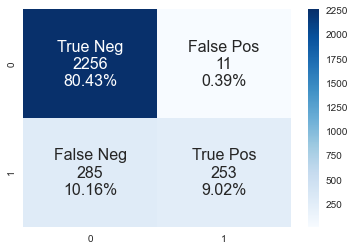

In [57]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix.flatten()/np.sum(confusion_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":16})

In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94      2267
         1.0       0.96      0.47      0.63       538

    accuracy                           0.89      2805
   macro avg       0.92      0.73      0.78      2805
weighted avg       0.90      0.89      0.88      2805



#### The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

#### The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

#### The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.
#### The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important.

#### The support is the number of occurrences of each class in y_test.

## 4. 2 Support Vector Machine 

In [59]:
from sklearn.svm import SVC
svm_clf = SVC(probability=True)
svm_clf.fit(X_train, y_train)

SVC(probability=True)

In [60]:
y_predSVM = svm_clf.predict(X_test)
print('Accuracy of classifier on training set: {:.4f}'.format(svm_clf.score(X_train, y_train)))
print('Accuracy of Support Vector Machine classifier on test set: {:.4f}'.format(svm_clf.score(X_test, y_test)))

Accuracy of classifier on training set: 0.9053
Accuracy of Support Vector Machine classifier on test set: 0.8952


### Accuracy of SVM classification is 89.52%

### Probabilities of output(1) of each entry

In [61]:
prob = svm_clf.predict_proba(X_test)
prob

array([[8.05026349e-01, 1.94973651e-01],
       [1.37657610e-02, 9.86234239e-01],
       [8.08392528e-01, 1.91607472e-01],
       ...,
       [7.92415610e-01, 2.07584390e-01],
       [8.08619502e-01, 1.91380498e-01],
       [1.02907564e-06, 9.99998971e-01]])

In [62]:
SVMProb = pd.DataFrame()

SVMProb['Probability of getting output 1'] = predict_probability[:,1]
SVMProb.head(20)

,Probability of getting output 1
0,0.42
1,0.79
2,0.34
3,0.25
4,0.00
5,1.00
6,0.00
7,0.31
8,0.00
9,0.00


### [ Optimising using GridSearchCV ]

In [63]:
parameters = {
     
    'C'       : [1,10],
    'kernel'  : ['rbf', 'linear'],
}

svm_clf = GridSearchCV(estimator=SVC(gamma='auto'), param_grid=parameters, cv= 5, verbose = 2,  return_train_score=True)
svm_clf.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] C=1, kernel=rbf .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. C=1, kernel=rbf, total=   0.3s
[CV] C=1, kernel=rbf .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .................................. C=1, kernel=rbf, total=   0.3s
[CV] C=1, kernel=rbf .................................................
[CV] .................................. C=1, kernel=rbf, total=   0.3s
[CV] C=1, kernel=rbf .................................................
[CV] .................................. C=1, kernel=rbf, total=   0.3s
[CV] C=1, kernel=rbf .................................................
[CV] .................................. C=1, kernel=rbf, total=   0.3s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=   0.4s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=   0.2s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=   0.2s
[CV] C=1, kernel=linear ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    9.6s finished


GridSearchCV(cv=5, estimator=SVC(gamma='auto'),
             param_grid={'C': [1, 10], 'kernel': ['rbf', 'linear']},
             return_train_score=True, verbose=2)

In [64]:
svm_clf.best_score_

0.906646294881589

In [65]:
svmOP = svm_clf.best_estimator_
svmOP

SVC(C=10, gamma='auto')

In [66]:
y_predSVM = svmOP.predict(X_test)
print('Accuracy of classifier on training set: {:.4f}'.format(svmOP.score(X_train, y_train)*100))
print('Accuracy of Support Vector Machine classifier on test set: {:.4f}'.format(svmOP.score(X_test, y_test)*100))

Accuracy of classifier on training set: 91.0772
Accuracy of Support Vector Machine classifier on test set: 89.8752


### Confusion matrix

In [67]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_predSVM)
print(confusion_matrix)

[[2254   13]
 [ 271  267]]


<AxesSubplot:>

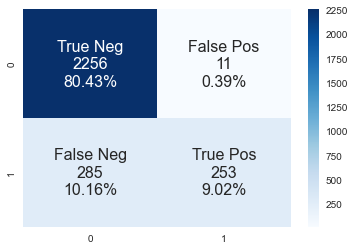

In [68]:
sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":16})

In [69]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predSVM))

              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94      2267
         1.0       0.95      0.50      0.65       538

    accuracy                           0.90      2805
   macro avg       0.92      0.75      0.80      2805
weighted avg       0.90      0.90      0.89      2805



## 4. 3 Decision tree

In [70]:
from sklearn.tree import DecisionTreeClassifier
DTclf_model = DecisionTreeClassifier(criterion="gini", random_state=1,max_depth=5, min_samples_leaf=1)   
DTclf_model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, random_state=1)

In [71]:
y_predDT = DTclf_model.predict(X_test)
print('Accuracy of classifier on training set: {:.4f}'.format(DTclf_model.score(X_train, y_train)))
print('Accuracy of Decision tree classifier on test set: {:.4f}'.format(DTclf_model.score(X_test, y_test)))

Accuracy of classifier on training set: 0.9060
Accuracy of Decision tree classifier on test set: 0.8991


### Accuracy of Decision tree classification is 90.00%

### [ Optimising using GridSearchCV ]

In [72]:
parameters = {'max_leaf_nodes': [3, 7, 10, 30, 40], 
          'min_samples_split': [4, 6, 8, 10],
          'max_depth':[4,5,6,7,8,10,13,17,20,30,50,100]}

DTclf_model = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=parameters, cv= 5, verbose = 2, return_train_score = True)
DTclf_model.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] max_depth=4, max_leaf_nodes=3, min_samples_split=4 ..............
[CV]  max_depth=4, max_leaf_nodes=3, min_samples_split=4, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=3, min_samples_split=4 ..............
[CV]  max_depth=4, max_leaf_nodes=3, min_samples_split=4, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=3, min_samples_split=4 ..............
[CV]  max_depth=4, max_leaf_nodes=3, min_samples_split=4, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=3, min_samples_split=4 ..............
[CV]  max_depth=4, max_leaf_nodes=3, min_samples_split=4, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=3, min_samples_split=4 ..............
[CV]  max_depth=4, max_leaf_nodes=3, min_samples_split=4, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=3, min_samples_split=6 ..............
[CV]  max_depth=4, max_leaf_nodes=3, min_samples_split=6, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=3, min_samples_split=6 ..............
[CV]  m

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  max_depth=4, max_leaf_nodes=7, min_samples_split=8, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=7, min_samples_split=8 ..............
[CV]  max_depth=4, max_leaf_nodes=7, min_samples_split=8, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=7, min_samples_split=10 .............
[CV]  max_depth=4, max_leaf_nodes=7, min_samples_split=10, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=7, min_samples_split=10 .............
[CV]  max_depth=4, max_leaf_nodes=7, min_samples_split=10, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=7, min_samples_split=10 .............
[CV]  max_depth=4, max_leaf_nodes=7, min_samples_split=10, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=7, min_samples_split=10 .............
[CV]  max_depth=4, max_leaf_nodes=7, min_samples_split=10, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=7, min_samples_split=10 .............
[CV]  max_depth=4, max_leaf_nodes=7, min_samples_split=10, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=10, min_samples_split=4 ........

[CV]  max_depth=5, max_leaf_nodes=3, min_samples_split=4, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=3, min_samples_split=6 ..............
[CV]  max_depth=5, max_leaf_nodes=3, min_samples_split=6, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=3, min_samples_split=6 ..............
[CV]  max_depth=5, max_leaf_nodes=3, min_samples_split=6, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=3, min_samples_split=6 ..............
[CV]  max_depth=5, max_leaf_nodes=3, min_samples_split=6, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=3, min_samples_split=6 ..............
[CV]  max_depth=5, max_leaf_nodes=3, min_samples_split=6, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=3, min_samples_split=6 ..............
[CV]  max_depth=5, max_leaf_nodes=3, min_samples_split=6, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=3, min_samples_split=8 ..............
[CV]  max_depth=5, max_leaf_nodes=3, min_samples_split=8, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=3, min_samples_split=8 ..............

[CV]  max_depth=5, max_leaf_nodes=30, min_samples_split=6, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=30, min_samples_split=6 .............
[CV]  max_depth=5, max_leaf_nodes=30, min_samples_split=6, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=30, min_samples_split=6 .............
[CV]  max_depth=5, max_leaf_nodes=30, min_samples_split=6, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=30, min_samples_split=6 .............
[CV]  max_depth=5, max_leaf_nodes=30, min_samples_split=6, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=30, min_samples_split=6 .............
[CV]  max_depth=5, max_leaf_nodes=30, min_samples_split=6, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=30, min_samples_split=8 .............
[CV]  max_depth=5, max_leaf_nodes=30, min_samples_split=8, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=30, min_samples_split=8 .............
[CV]  max_depth=5, max_leaf_nodes=30, min_samples_split=8, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=30, min_samples_split=8 ......

[CV]  max_depth=6, max_leaf_nodes=7, min_samples_split=8, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=7, min_samples_split=8 ..............
[CV]  max_depth=6, max_leaf_nodes=7, min_samples_split=8, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=7, min_samples_split=8 ..............
[CV]  max_depth=6, max_leaf_nodes=7, min_samples_split=8, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=7, min_samples_split=8 ..............
[CV]  max_depth=6, max_leaf_nodes=7, min_samples_split=8, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=7, min_samples_split=8 ..............
[CV]  max_depth=6, max_leaf_nodes=7, min_samples_split=8, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=7, min_samples_split=10 .............
[CV]  max_depth=6, max_leaf_nodes=7, min_samples_split=10, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=7, min_samples_split=10 .............
[CV]  max_depth=6, max_leaf_nodes=7, min_samples_split=10, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=7, min_samples_split=10 ...........

[CV]  max_depth=6, max_leaf_nodes=40, min_samples_split=8, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=40, min_samples_split=8 .............
[CV]  max_depth=6, max_leaf_nodes=40, min_samples_split=8, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=40, min_samples_split=8 .............
[CV]  max_depth=6, max_leaf_nodes=40, min_samples_split=8, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=40, min_samples_split=8 .............
[CV]  max_depth=6, max_leaf_nodes=40, min_samples_split=8, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=40, min_samples_split=8 .............
[CV]  max_depth=6, max_leaf_nodes=40, min_samples_split=8, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=40, min_samples_split=10 ............
[CV]  max_depth=6, max_leaf_nodes=40, min_samples_split=10, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=40, min_samples_split=10 ............
[CV]  max_depth=6, max_leaf_nodes=40, min_samples_split=10, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=40, min_samples_split=10 ...

[CV]  max_depth=7, max_leaf_nodes=10, min_samples_split=8, total=   0.0s
[CV] max_depth=7, max_leaf_nodes=10, min_samples_split=8 .............
[CV]  max_depth=7, max_leaf_nodes=10, min_samples_split=8, total=   0.0s
[CV] max_depth=7, max_leaf_nodes=10, min_samples_split=10 ............
[CV]  max_depth=7, max_leaf_nodes=10, min_samples_split=10, total=   0.0s
[CV] max_depth=7, max_leaf_nodes=10, min_samples_split=10 ............
[CV]  max_depth=7, max_leaf_nodes=10, min_samples_split=10, total=   0.0s
[CV] max_depth=7, max_leaf_nodes=10, min_samples_split=10 ............
[CV]  max_depth=7, max_leaf_nodes=10, min_samples_split=10, total=   0.0s
[CV] max_depth=7, max_leaf_nodes=10, min_samples_split=10 ............
[CV]  max_depth=7, max_leaf_nodes=10, min_samples_split=10, total=   0.0s
[CV] max_depth=7, max_leaf_nodes=10, min_samples_split=10 ............
[CV]  max_depth=7, max_leaf_nodes=10, min_samples_split=10, total=   0.0s
[CV] max_depth=7, max_leaf_nodes=30, min_samples_split=4 .

[CV]  max_depth=8, max_leaf_nodes=10, min_samples_split=4, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=10, min_samples_split=4 .............
[CV]  max_depth=8, max_leaf_nodes=10, min_samples_split=4, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=10, min_samples_split=6 .............
[CV]  max_depth=8, max_leaf_nodes=10, min_samples_split=6, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=10, min_samples_split=6 .............
[CV]  max_depth=8, max_leaf_nodes=10, min_samples_split=6, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=10, min_samples_split=6 .............
[CV]  max_depth=8, max_leaf_nodes=10, min_samples_split=6, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=10, min_samples_split=6 .............
[CV]  max_depth=8, max_leaf_nodes=10, min_samples_split=6, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=10, min_samples_split=6 .............
[CV]  max_depth=8, max_leaf_nodes=10, min_samples_split=6, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=10, min_samples_split=8 ......

[CV] max_depth=10, max_leaf_nodes=3, min_samples_split=10 ............
[CV]  max_depth=10, max_leaf_nodes=3, min_samples_split=10, total=   0.0s
[CV] max_depth=10, max_leaf_nodes=3, min_samples_split=10 ............
[CV]  max_depth=10, max_leaf_nodes=3, min_samples_split=10, total=   0.0s
[CV] max_depth=10, max_leaf_nodes=3, min_samples_split=10 ............
[CV]  max_depth=10, max_leaf_nodes=3, min_samples_split=10, total=   0.0s
[CV] max_depth=10, max_leaf_nodes=7, min_samples_split=4 .............
[CV]  max_depth=10, max_leaf_nodes=7, min_samples_split=4, total=   0.0s
[CV] max_depth=10, max_leaf_nodes=7, min_samples_split=4 .............
[CV]  max_depth=10, max_leaf_nodes=7, min_samples_split=4, total=   0.0s
[CV] max_depth=10, max_leaf_nodes=7, min_samples_split=4 .............
[CV]  max_depth=10, max_leaf_nodes=7, min_samples_split=4, total=   0.0s
[CV] max_depth=10, max_leaf_nodes=7, min_samples_split=4 .............
[CV]  max_depth=10, max_leaf_nodes=7, min_samples_split=4, tot

[CV]  max_depth=10, max_leaf_nodes=40, min_samples_split=4, total=   0.0s
[CV] max_depth=10, max_leaf_nodes=40, min_samples_split=4 ............
[CV]  max_depth=10, max_leaf_nodes=40, min_samples_split=4, total=   0.0s
[CV] max_depth=10, max_leaf_nodes=40, min_samples_split=4 ............
[CV]  max_depth=10, max_leaf_nodes=40, min_samples_split=4, total=   0.0s
[CV] max_depth=10, max_leaf_nodes=40, min_samples_split=6 ............
[CV]  max_depth=10, max_leaf_nodes=40, min_samples_split=6, total=   0.0s
[CV] max_depth=10, max_leaf_nodes=40, min_samples_split=6 ............
[CV]  max_depth=10, max_leaf_nodes=40, min_samples_split=6, total=   0.0s
[CV] max_depth=10, max_leaf_nodes=40, min_samples_split=6 ............
[CV]  max_depth=10, max_leaf_nodes=40, min_samples_split=6, total=   0.0s
[CV] max_depth=10, max_leaf_nodes=40, min_samples_split=6 ............
[CV]  max_depth=10, max_leaf_nodes=40, min_samples_split=6, total=   0.0s
[CV] max_depth=10, max_leaf_nodes=40, min_samples_split=

[CV]  max_depth=13, max_leaf_nodes=10, min_samples_split=10, total=   0.0s
[CV] max_depth=13, max_leaf_nodes=10, min_samples_split=10 ...........
[CV]  max_depth=13, max_leaf_nodes=10, min_samples_split=10, total=   0.0s
[CV] max_depth=13, max_leaf_nodes=10, min_samples_split=10 ...........
[CV]  max_depth=13, max_leaf_nodes=10, min_samples_split=10, total=   0.0s
[CV] max_depth=13, max_leaf_nodes=10, min_samples_split=10 ...........
[CV]  max_depth=13, max_leaf_nodes=10, min_samples_split=10, total=   0.0s
[CV] max_depth=13, max_leaf_nodes=30, min_samples_split=4 ............
[CV]  max_depth=13, max_leaf_nodes=30, min_samples_split=4, total=   0.0s
[CV] max_depth=13, max_leaf_nodes=30, min_samples_split=4 ............
[CV]  max_depth=13, max_leaf_nodes=30, min_samples_split=4, total=   0.0s
[CV] max_depth=13, max_leaf_nodes=30, min_samples_split=4 ............
[CV]  max_depth=13, max_leaf_nodes=30, min_samples_split=4, total=   0.0s
[CV] max_depth=13, max_leaf_nodes=30, min_samples_sp

[CV]  max_depth=17, max_leaf_nodes=3, min_samples_split=10, total=   0.0s
[CV] max_depth=17, max_leaf_nodes=3, min_samples_split=10 ............
[CV]  max_depth=17, max_leaf_nodes=3, min_samples_split=10, total=   0.0s
[CV] max_depth=17, max_leaf_nodes=7, min_samples_split=4 .............
[CV]  max_depth=17, max_leaf_nodes=7, min_samples_split=4, total=   0.0s
[CV] max_depth=17, max_leaf_nodes=7, min_samples_split=4 .............
[CV]  max_depth=17, max_leaf_nodes=7, min_samples_split=4, total=   0.0s
[CV] max_depth=17, max_leaf_nodes=7, min_samples_split=4 .............
[CV]  max_depth=17, max_leaf_nodes=7, min_samples_split=4, total=   0.0s
[CV] max_depth=17, max_leaf_nodes=7, min_samples_split=4 .............
[CV]  max_depth=17, max_leaf_nodes=7, min_samples_split=4, total=   0.0s
[CV] max_depth=17, max_leaf_nodes=7, min_samples_split=4 .............
[CV]  max_depth=17, max_leaf_nodes=7, min_samples_split=4, total=   0.0s
[CV] max_depth=17, max_leaf_nodes=7, min_samples_split=6 ....

[CV]  max_depth=17, max_leaf_nodes=40, min_samples_split=4, total=   0.0s
[CV] max_depth=17, max_leaf_nodes=40, min_samples_split=6 ............
[CV]  max_depth=17, max_leaf_nodes=40, min_samples_split=6, total=   0.0s
[CV] max_depth=17, max_leaf_nodes=40, min_samples_split=6 ............
[CV]  max_depth=17, max_leaf_nodes=40, min_samples_split=6, total=   0.0s
[CV] max_depth=17, max_leaf_nodes=40, min_samples_split=6 ............
[CV]  max_depth=17, max_leaf_nodes=40, min_samples_split=6, total=   0.0s
[CV] max_depth=17, max_leaf_nodes=40, min_samples_split=6 ............
[CV]  max_depth=17, max_leaf_nodes=40, min_samples_split=6, total=   0.0s
[CV] max_depth=17, max_leaf_nodes=40, min_samples_split=6 ............
[CV]  max_depth=17, max_leaf_nodes=40, min_samples_split=6, total=   0.0s
[CV] max_depth=17, max_leaf_nodes=40, min_samples_split=8 ............
[CV]  max_depth=17, max_leaf_nodes=40, min_samples_split=8, total=   0.0s
[CV] max_depth=17, max_leaf_nodes=40, min_samples_split=

[CV]  max_depth=20, max_leaf_nodes=10, min_samples_split=8, total=   0.0s
[CV] max_depth=20, max_leaf_nodes=10, min_samples_split=8 ............
[CV]  max_depth=20, max_leaf_nodes=10, min_samples_split=8, total=   0.0s
[CV] max_depth=20, max_leaf_nodes=10, min_samples_split=10 ...........
[CV]  max_depth=20, max_leaf_nodes=10, min_samples_split=10, total=   0.0s
[CV] max_depth=20, max_leaf_nodes=10, min_samples_split=10 ...........
[CV]  max_depth=20, max_leaf_nodes=10, min_samples_split=10, total=   0.0s
[CV] max_depth=20, max_leaf_nodes=10, min_samples_split=10 ...........
[CV]  max_depth=20, max_leaf_nodes=10, min_samples_split=10, total=   0.0s
[CV] max_depth=20, max_leaf_nodes=10, min_samples_split=10 ...........
[CV]  max_depth=20, max_leaf_nodes=10, min_samples_split=10, total=   0.0s
[CV] max_depth=20, max_leaf_nodes=10, min_samples_split=10 ...........
[CV]  max_depth=20, max_leaf_nodes=10, min_samples_split=10, total=   0.0s
[CV] max_depth=20, max_leaf_nodes=30, min_samples_s

[CV]  max_depth=30, max_leaf_nodes=7, min_samples_split=4, total=   0.0s
[CV] max_depth=30, max_leaf_nodes=7, min_samples_split=4 .............
[CV]  max_depth=30, max_leaf_nodes=7, min_samples_split=4, total=   0.0s
[CV] max_depth=30, max_leaf_nodes=7, min_samples_split=4 .............
[CV]  max_depth=30, max_leaf_nodes=7, min_samples_split=4, total=   0.0s
[CV] max_depth=30, max_leaf_nodes=7, min_samples_split=4 .............
[CV]  max_depth=30, max_leaf_nodes=7, min_samples_split=4, total=   0.0s
[CV] max_depth=30, max_leaf_nodes=7, min_samples_split=4 .............
[CV]  max_depth=30, max_leaf_nodes=7, min_samples_split=4, total=   0.0s
[CV] max_depth=30, max_leaf_nodes=7, min_samples_split=6 .............
[CV]  max_depth=30, max_leaf_nodes=7, min_samples_split=6, total=   0.0s
[CV] max_depth=30, max_leaf_nodes=7, min_samples_split=6 .............
[CV]  max_depth=30, max_leaf_nodes=7, min_samples_split=6, total=   0.0s
[CV] max_depth=30, max_leaf_nodes=7, min_samples_split=6 ......

[CV]  max_depth=30, max_leaf_nodes=40, min_samples_split=10, total=   0.0s
[CV] max_depth=30, max_leaf_nodes=40, min_samples_split=10 ...........
[CV]  max_depth=30, max_leaf_nodes=40, min_samples_split=10, total=   0.0s
[CV] max_depth=30, max_leaf_nodes=40, min_samples_split=10 ...........
[CV]  max_depth=30, max_leaf_nodes=40, min_samples_split=10, total=   0.0s
[CV] max_depth=30, max_leaf_nodes=40, min_samples_split=10 ...........
[CV]  max_depth=30, max_leaf_nodes=40, min_samples_split=10, total=   0.0s
[CV] max_depth=30, max_leaf_nodes=40, min_samples_split=10 ...........
[CV]  max_depth=30, max_leaf_nodes=40, min_samples_split=10, total=   0.0s
[CV] max_depth=50, max_leaf_nodes=3, min_samples_split=4 .............
[CV]  max_depth=50, max_leaf_nodes=3, min_samples_split=4, total=   0.0s
[CV] max_depth=50, max_leaf_nodes=3, min_samples_split=4 .............
[CV]  max_depth=50, max_leaf_nodes=3, min_samples_split=4, total=   0.0s
[CV] max_depth=50, max_leaf_nodes=3, min_samples_spli

[CV]  max_depth=50, max_leaf_nodes=30, min_samples_split=6, total=   0.0s
[CV] max_depth=50, max_leaf_nodes=30, min_samples_split=8 ............
[CV]  max_depth=50, max_leaf_nodes=30, min_samples_split=8, total=   0.0s
[CV] max_depth=50, max_leaf_nodes=30, min_samples_split=8 ............
[CV]  max_depth=50, max_leaf_nodes=30, min_samples_split=8, total=   0.0s
[CV] max_depth=50, max_leaf_nodes=30, min_samples_split=8 ............
[CV]  max_depth=50, max_leaf_nodes=30, min_samples_split=8, total=   0.0s
[CV] max_depth=50, max_leaf_nodes=30, min_samples_split=8 ............
[CV]  max_depth=50, max_leaf_nodes=30, min_samples_split=8, total=   0.0s
[CV] max_depth=50, max_leaf_nodes=30, min_samples_split=8 ............
[CV]  max_depth=50, max_leaf_nodes=30, min_samples_split=8, total=   0.0s
[CV] max_depth=50, max_leaf_nodes=30, min_samples_split=10 ...........
[CV]  max_depth=50, max_leaf_nodes=30, min_samples_split=10, total=   0.0s
[CV] max_depth=50, max_leaf_nodes=30, min_samples_split

[CV]  max_depth=100, max_leaf_nodes=10, min_samples_split=8, total=   0.0s
[CV] max_depth=100, max_leaf_nodes=10, min_samples_split=8 ...........
[CV]  max_depth=100, max_leaf_nodes=10, min_samples_split=8, total=   0.0s
[CV] max_depth=100, max_leaf_nodes=10, min_samples_split=8 ...........
[CV]  max_depth=100, max_leaf_nodes=10, min_samples_split=8, total=   0.0s
[CV] max_depth=100, max_leaf_nodes=10, min_samples_split=8 ...........
[CV]  max_depth=100, max_leaf_nodes=10, min_samples_split=8, total=   0.0s
[CV] max_depth=100, max_leaf_nodes=10, min_samples_split=8 ...........
[CV]  max_depth=100, max_leaf_nodes=10, min_samples_split=8, total=   0.0s
[CV] max_depth=100, max_leaf_nodes=10, min_samples_split=10 ..........
[CV]  max_depth=100, max_leaf_nodes=10, min_samples_split=10, total=   0.0s
[CV] max_depth=100, max_leaf_nodes=10, min_samples_split=10 ..........
[CV]  max_depth=100, max_leaf_nodes=10, min_samples_split=10, total=   0.0s
[CV] max_depth=100, max_leaf_nodes=10, min_samp

[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    8.7s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 10, 13, 17, 20, 30, 50,
                                       100],
                         'max_leaf_nodes': [3, 7, 10, 30, 40],
                         'min_samples_split': [4, 6, 8, 10]},
             return_train_score=True, verbose=2)

In [73]:
# Mean training score
np.average(DTclf_model.cv_results_['mean_train_score'])

0.9011681945505475

In [74]:
#Mean testing score
DTclf_model.best_score_

0.9101604278074866

#### Accuracy improved from 89.91 to 91.19

In [75]:
DTclf_model.best_params_

{'max_depth': 7, 'max_leaf_nodes': 30, 'min_samples_split': 8}

In [76]:
y_predDT = DTclf_model.predict(X_test)
print('Accuracy of classifier on training set: {:.4f}'.format(DTclf_model.score(X_train, y_train)))
print('Accuracy of Decision tree classifier on test set: {:.4f}'.format(DTclf_model.score(X_test, y_test)))

Accuracy of classifier on training set: 0.9144
Accuracy of Decision tree classifier on test set: 0.9055


### Confusion matrix

In [77]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_predDT)
print(confusion_matrix)

[[2266    1]
 [ 264  274]]


<AxesSubplot:>

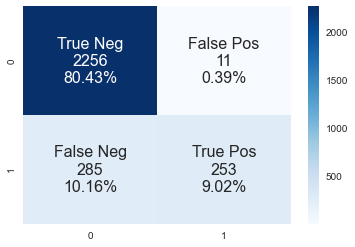

In [78]:
sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":16})

In [79]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predDT))

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.94      2267
         1.0       1.00      0.51      0.67       538

    accuracy                           0.91      2805
   macro avg       0.95      0.75      0.81      2805
weighted avg       0.91      0.91      0.89      2805



## 4.3.1 XG Boost 

In [80]:


from xgboost import XGBClassifier
xgb_clf = XGBClassifier(learning_rate=0.5, n_estimators=150, base_score=0.5)
xgb_clf.fit(X_train, y_train)
y_predXG = xgb_clf.predict(X_test)
print('Accuracy of classifier on training set: {:.4f}'.format(xgb_clf.score(X_train, y_train)))
print('Accuracy of Extreme Gradient Boosting classifier on test set: {:.4f}'.format(xgb_clf.score(X_test, y_test)))


Accuracy of classifier on training set: 0.9662
Accuracy of Extreme Gradient Boosting classifier on test set: 0.8799


### [ Optimising using GridSearchCV ]

In [81]:
param_grid = { 
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

xgb_clf = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv= 5, verbose = 2, n_jobs = 10, return_train_score=True)
xgb_clf.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    8.2s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   27.8s
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed:   58.5s
[Parallel(n_jobs=10)]: Done 480 out of 480 | elapsed:  1.4min finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                  

In [82]:
xgb_clf.best_score_

0.9124522536287243

In [83]:
xgb_clf.best_params_

{'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100}

In [84]:
y_predXG = xgb_clf.predict(X_test)
print('Accuracy of classifier on training set: {:.4f}'.format(xgb_clf.score(X_train, y_train)*100))
print('Accuracy of XGBoost classifier on test set: {:.4f}'.format(xgb_clf.score(X_test, y_test)*100))

Accuracy of classifier on training set: 91.6119
Accuracy of XGBoost classifier on test set: 90.5882


### Confusion matrix

In [85]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_predXG)
print(confusion_matrix)

[[2261    6]
 [ 258  280]]


<AxesSubplot:>

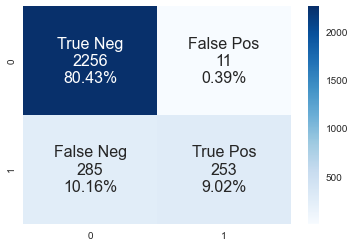

In [86]:
sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":16})

In [87]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predXG))

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.94      2267
         1.0       0.98      0.52      0.68       538

    accuracy                           0.91      2805
   macro avg       0.94      0.76      0.81      2805
weighted avg       0.91      0.91      0.89      2805



## 4. 4 Random Forest

In [88]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=1500, oob_score=True)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1500, oob_score=True)

In [89]:
y_predRF = rf_clf.predict(X_test)
print('Accuracy of Random Forest classifier on training set: {:.4f}'.format(rf_clf.score(X_train, y_train)))

print('Accuracy of Random Forest classifier on test set: {:.4f}'.format(rf_clf.score(X_test, y_test)))

Accuracy of Random Forest classifier on training set: 0.9806
Accuracy of Random Forest classifier on test set: 0.8717


### We Doesn't want our Model to be Overfitted 
#### so We Limit the number of trees that will gonna update our model

#### Also Finding the optimal depth of Tree to split each node to a desired number of observations

In [130]:
rf_clf1 = RandomForestClassifier(n_estimators=1500, oob_score=True,max_depth=5)
rf_clf1.fit(X_train, y_train)
y_predRF = rf_clf1.predict(X_test)
print('Accuracy of Random Forest classifier on training set: {:.4f}'.format(rf_clf1.score(X_train, y_train)))

print('Accuracy of Random Forest classifier on test set: {:.4f}'.format(rf_clf1.score(X_test, y_test)))

Accuracy of Random Forest classifier on training set: 0.9112
Accuracy of Random Forest classifier on test set: 0.8995


### Accuracy of Random Forest is 90.00%

### [ Optimising using GridSearchCV ]

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'n_estimators': [200, 700,1500,2000],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= 5, verbose = 2, return_train_score=True)
rf_clf.fit(X_train, y_train)



Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_features=auto, n_estimators=200 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............. max_features=auto, n_estimators=200, total=   0.9s
[CV] max_features=auto, n_estimators=200 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] .............. max_features=auto, n_estimators=200, total=   0.9s
[CV] max_features=auto, n_estimators=200 .............................
[CV] .............. max_features=auto, n_estimators=200, total=   0.8s
[CV] max_features=auto, n_estimators=200 .............................
[CV] .............. max_features=auto, n_estimators=200, total=   0.9s
[CV] max_features=auto, n_estimators=200 .............................
[CV] .............. max_features=auto, n_estimators=200, total=   0.9s
[CV] max_features=auto, n_estimators=700 .............................
[CV] .............. max_features=auto, n_estimators=700, total=   3.0s
[CV] max_features=auto, n_estimators=700 .............................
[CV] .............. max_features=auto, n_estimators=700, total=   2.9s
[CV] max_features=auto, n_estimators=700 .............................
[CV] .............. max_features=auto, n_estimators=700, total=   3.0s
[CV] max_features=auto, n_estimators=700 .............................
[CV] .

[CV] ............. max_features=log2, n_estimators=2000, total=   9.1s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  5.8min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 700, 1500, 2000]},
             return_train_score=True, verbose=2)

In [93]:
rf_clf.best_score_

0.8796027501909854

In [94]:
rf_clf.best_params_

{'max_features': 'auto', 'n_estimators': 200}

In [95]:
y_predRF = rf_clf.predict(X_test)
print('Accuracy of Random Forest classifier on training set: {:.4f}'.format(rf_clf.score(X_train, y_train)))
print('Accuracy of Random Forest classifier on test set: {:.4f}'.format(rf_clf.score(X_test, y_test)))

Accuracy of Random Forest classifier on training set: 0.9806
Accuracy of Random Forest classifier on test set: 0.8699


In [96]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_predRF)
print(confusion_matrix)

[[2111  156]
 [ 209  329]]


<AxesSubplot:>

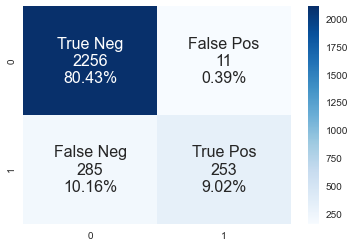

In [97]:
sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":16})

In [98]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predRF))

              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      2267
         1.0       0.68      0.61      0.64       538

    accuracy                           0.87      2805
   macro avg       0.79      0.77      0.78      2805
weighted avg       0.87      0.87      0.87      2805



In [99]:
print(classification_report(y_test, y_predRF))

              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      2267
         1.0       0.68      0.61      0.64       538

    accuracy                           0.87      2805
   macro avg       0.79      0.77      0.78      2805
weighted avg       0.87      0.87      0.87      2805



## 4.6 Neural network

In [100]:
scaled_inputs = X

#### Shuffling

In [101]:
scaled_inputs.shape[0]

9350

In [102]:
#ON SHUFFLING --> shuffled_inputs = scaled_inputs[shuffled_indices]
#                 shuffled_targets = y[shuffled_indices]

#following error was coming
#         # take() does not accept boolean indexers
# KeyError: "None of [Int64Index([8346, 1990, 1572, 7182, 4024, 7023, 2579, 3347, 6357, 3399,\n            ...\n            6354, 2956, 2961, 2840, 9204, 6510, 1736, 6907, 2988, 2011],\n           dtype='int64', length=9350)] are in the [columns]"

# Because Y is still a dataframe, convert it into numpy array

outputs = y.to_numpy()
outputs.shape

(9350, 1)

In [103]:
shuffled_indices = np.arange(scaled_inputs.shape[0])
np.random.shuffle(shuffled_indices)

# Use the shuffled indices to shuffle the inputs and targets.
shuffled_inputs = scaled_inputs[shuffled_indices]
shuffled_targets = outputs[shuffled_indices]

### Train, Test, Validation

In [104]:
samples_count = shuffled_inputs.shape[0]

# Count the samples in each subset, assuming we want 80-10-10 distribution of training, validation, and test.
# Naturally, the numbers are integers.
train_samples_count = int(0.8 * samples_count)
validation_samples_count = int(0.1 * samples_count)

# The 'test' dataset contains all remaining data.
test_samples_count = samples_count - train_samples_count - validation_samples_count

# Create variables that record the inputs and targets for training
# In our shuffled dataset, they are the first "train_samples_count" observations
train_inputs = shuffled_inputs[:train_samples_count]
train_targets = shuffled_targets[:train_samples_count]

# Create variables that record the inputs and targets for validation.
# They are the next "validation_samples_count" observations, folllowing the "train_samples_count" we already assigned
validation_inputs = shuffled_inputs[train_samples_count:train_samples_count+validation_samples_count]
validation_targets = shuffled_targets[train_samples_count:train_samples_count+validation_samples_count]

# Create variables that record the inputs and targets for test.
# They are everything that is remaining.
test_inputs = shuffled_inputs[train_samples_count+validation_samples_count:]
test_targets = shuffled_targets[train_samples_count+validation_samples_count:]

# Print the number of targets that are 1s, the total number of samples, and the proportion for training, validation, and test.
print(np.sum(train_targets), train_samples_count, np.sum(train_targets) / train_samples_count)
print(np.sum(validation_targets), validation_samples_count, np.sum(validation_targets) / validation_samples_count)
print(np.sum(test_targets), test_samples_count, np.sum(test_targets) / test_samples_count)

1449.0 7480 0.19371657754010696
209.0 935 0.2235294117647059
144.0 935 0.15401069518716579


In [111]:
# Set the input and output sizes
input_size = 10
output_size = 2

hidden_layer_size = 50
    

model = tf.keras.Sequential([
    tf.keras.layers.Dense(input_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), 
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), 
    tf.keras.layers.Dense(output_size, activation='softmax') 
])


### Choose the optimizer and the loss function

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Training

batch_size = 100

# set a maximum number of training epochs
max_epochs = 100
# set an early stopping mechanism
# let's set patience=2, to be a bit tolerant against random validation loss increases
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

# fit the model
history = model.fit(train_inputs, 
          train_targets, 
          batch_size=batch_size, 
          epochs=max_epochs, 
          # callbacks are functions to check if val_loss is increasing
          callbacks=[early_stopping], 
          validation_data=(validation_inputs, validation_targets),
          verbose = 2
          )  

Epoch 1/100
75/75 - 0s - loss: 0.4766 - accuracy: 0.8060 - val_loss: 0.4011 - val_accuracy: 0.8513
Epoch 2/100
75/75 - 0s - loss: 0.3280 - accuracy: 0.8731 - val_loss: 0.3192 - val_accuracy: 0.8695
Epoch 3/100
75/75 - 0s - loss: 0.2813 - accuracy: 0.8854 - val_loss: 0.2807 - val_accuracy: 0.8781
Epoch 4/100
75/75 - 0s - loss: 0.2602 - accuracy: 0.8892 - val_loss: 0.2651 - val_accuracy: 0.8791
Epoch 5/100
75/75 - 0s - loss: 0.2470 - accuracy: 0.8922 - val_loss: 0.2499 - val_accuracy: 0.8856
Epoch 6/100
75/75 - 0s - loss: 0.2375 - accuracy: 0.8948 - val_loss: 0.2412 - val_accuracy: 0.8920
Epoch 7/100
75/75 - 0s - loss: 0.2309 - accuracy: 0.8977 - val_loss: 0.2364 - val_accuracy: 0.8930
Epoch 8/100
75/75 - 0s - loss: 0.2272 - accuracy: 0.8972 - val_loss: 0.2349 - val_accuracy: 0.8834
Epoch 9/100
75/75 - 0s - loss: 0.2234 - accuracy: 0.9004 - val_loss: 0.2336 - val_accuracy: 0.8888
Epoch 10/100
75/75 - 0s - loss: 0.2221 - accuracy: 0.8999 - val_loss: 0.2246 - val_accuracy: 0.8898
Epoch 11/

In [112]:
test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)

30/30 [==============================] - 0s 900us/step - loss: 0.2012 - accuracy: 0.9155


### Accuracy of Neural Network is 91.55%

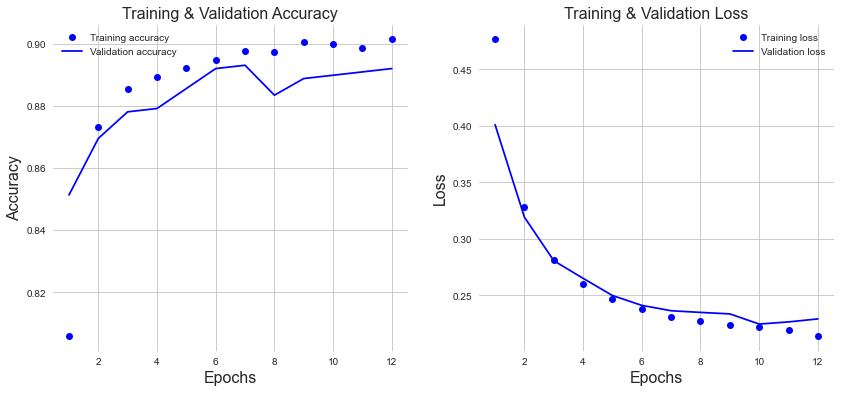

In [113]:
import matplotlib.pyplot as plt
 
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

## Comparing Machine Learning Models

In [133]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


ml_models = {
    'Logistic Regression': logreg, 
   'Random Forest': rf_clf1, 
    'XGboost': xgb_clf,
    'Decision Tree':DTclf_model,
#    'KNN': knn_clf
#    'SVM': svm_clf
}

LOGISTIC REGRESSION ACCURACY: 89.447
RANDOM FOREST ACCURACY: 89.947
XGBOOST ACCURACY: 90.588
DECISION TREE ACCURACY: 90.553


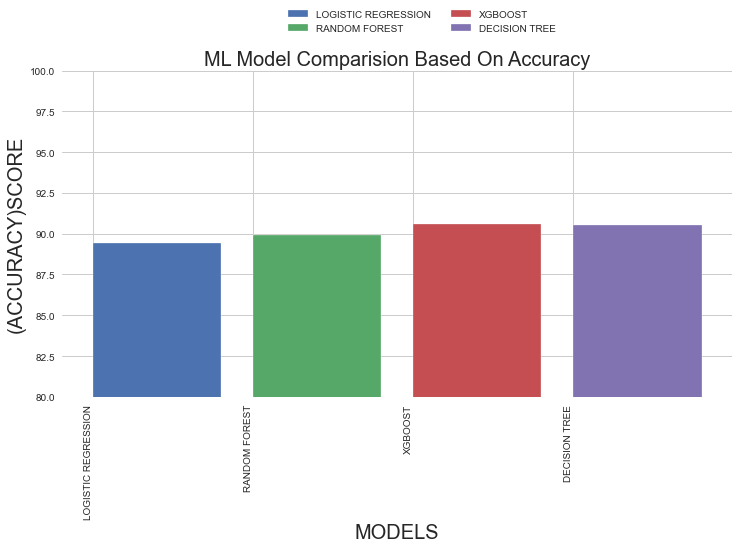

In [134]:
plt.figure(figsize=(12,6))

for model in ml_models:
    print(f"{model.upper()} ACCURACY: {ml_models[model].score(X_test,y_test)*100:.3f}")
    plt.bar(model.upper(),ml_models[model].score(X_test,y_test)*100,label=model.upper(),align="edge")
plt.title("ML Model Comparision Based On Accuracy",fontsize=20)
plt.xlabel("MODELS",fontsize=20)
plt.xticks(rotation=90,ha='right')
plt.ylim([80, 100])
plt.ylabel("(ACCURACY)SCORE",fontsize=20)
plt.legend(bbox_to_anchor =(0.75, 1.15), ncol = 2,loc ="right")
plt.show()


LOGISTIC REGRESSION roc_auc_score: 0.733
RANDOM FOREST roc_auc_score: 0.746
XGBOOST roc_auc_score: 0.759
DECISION TREE roc_auc_score: 0.754


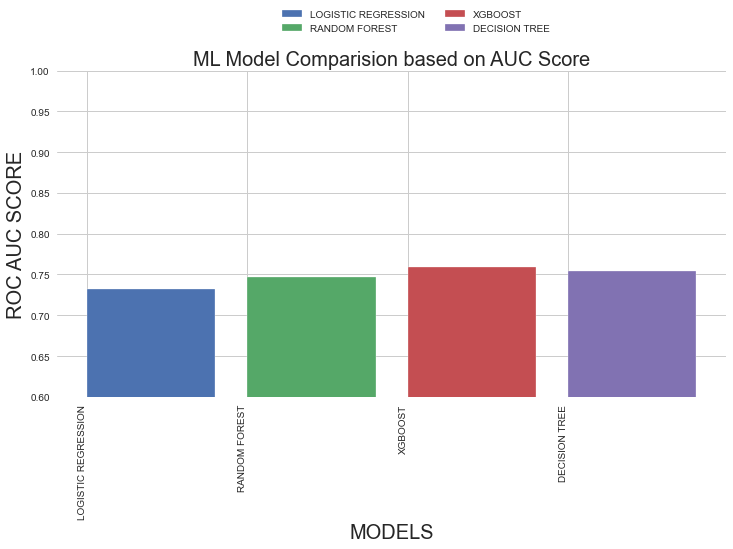

In [135]:
plt.figure(figsize=(12,6))

for model in ml_models:
    print(f"{model.upper()} roc_auc_score: {roc_auc_score(y_test, ml_models[model].predict(X_test)):.3f}")
    plt.bar(model.upper(),roc_auc_score(y_test, ml_models[model].predict(X_test)),label=model.upper(),align="edge")
plt.title("ML Model Comparision based on AUC Score",fontsize=20)
plt.xlabel("MODELS",fontsize=20)
plt.xticks(rotation=90,ha='right')
plt.ylim([0.6, 1])
plt.ylabel("ROC AUC SCORE",fontsize=20)
plt.legend(bbox_to_anchor =(0.75, 1.15), ncol = 2,loc ="right")
plt.show()


## ROC Curve (Receiver Operating Characteristic Curve)

In [136]:
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

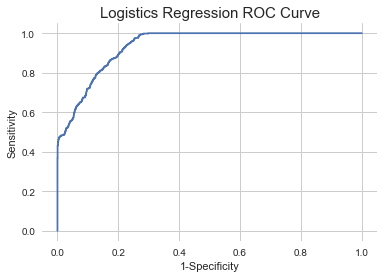

In [137]:
#Logisitic Regression
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

plt.plot(fpr,tpr)
plt.title("Logistics Regression ROC Curve",fontsize=15)
plt.ylabel('Sensitivity')  #True Positive Rate
plt.xlabel('1-Specificity')  #False Positive Rate
plt.show()

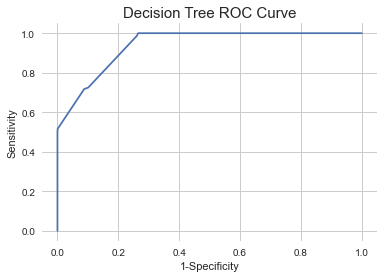

In [138]:
#Decision Tree
y_pred_proba = DTclf_model.predict_proba(X_test)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_pred_proba)
plt.title("Decision Tree ROC Curve",fontsize=15)

plt.plot(fpr1,tpr1)
plt.ylabel('Sensitivity')  #True Positive Rate
plt.xlabel('1-Specificity')  #False Positive Rate
plt.show()

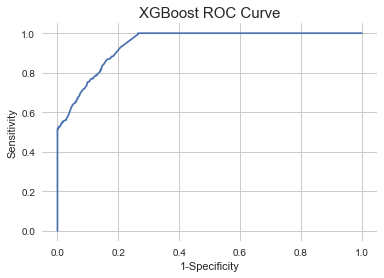

In [139]:
#XGBOOST
y_pred_proba = xgb_clf.predict_proba(X_test)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test,  y_pred_proba)
plt.title("XGBoost ROC Curve",fontsize=15)
plt.plot(fpr2,tpr2)
plt.ylabel('Sensitivity')  #True Positive Rate
plt.xlabel('1-Specificity')  #False Positive Rate
plt.show()

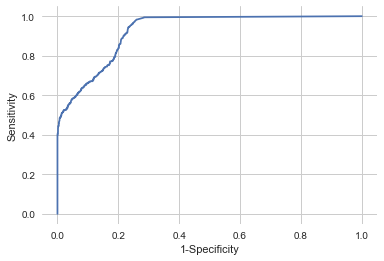

In [140]:
#Random Forest
y_pred_proba = rf_clf.predict_proba(X_test)[::,1]
fpr3, tpr3, _ = metrics.roc_curve(y_test,  y_pred_proba)

plt.plot(fpr3,tpr3)
plt.ylabel('Sensitivity')  #True Positive Rate
plt.xlabel('1-Specificity')  #False Positive Rate
plt.show()

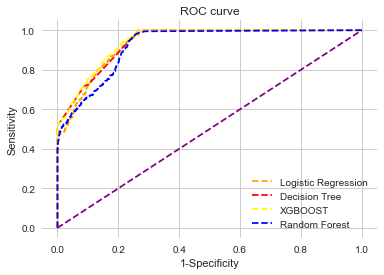

In [141]:
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr1, tpr1, linestyle='--',color='red', label='Decision Tree')
plt.plot(fpr2, tpr2, linestyle='--',color='yellow', label='XGBOOST')
plt.plot(fpr3, tpr3, linestyle='--',color='blue', label='Random Forest')

plt.plot(p_fpr, p_tpr, linestyle='--', color='purple')
plt.title('ROC curve') #Receiver Operating Characteristic Curve
plt.xlabel('1-Specificity') #False Positive Rate
plt.ylabel('Sensitivity')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();